# TensoRF Color Variance

## Imports

In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.tensoRF import TensorVMSplit

In [ ]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(20211202)
np.random.seed(20211202)

## Load Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load('trained_models/tensorf_trex_VM.th', map_location=device)
kwargs = ckpt['kwargs']
kwargs.update({'device': device})
tensorf = TensorVMSplit(**kwargs)
tensorf.load(ckpt)

aabb tensor([-1.5000, -1.6700, -1.0000,  1.5000,  1.6700,  1.0000], device='cuda:0')
grid size [706, 786, 471]
sampling step size:  tensor(0.0021, device='cuda:0')
sampling number:  2311
pos_pe 6 view_pe 0 fea_pe 0
MLPRender_Fea(
  (mlp): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


## Find Color Variance

In [ ]:
ray = torch.tensor([[ 1.2144,  1.4356, -1.0000, -0.5201, -0.6335,  2.0000]]).to(device) # x,y,z, dx,dy,dz
ray[:, 3:6]

tensor([[-0.5201, -0.6335,  2.0000]], device='cuda:0')

In [ ]:
with torch.no_grad():
    tensorf.eval()
    output = tensorf.forward(ray)

rgb_map, depth, rgb, sigma, xyz_sampled = output

rgb = rgb[0].cpu().numpy()
sigma = sigma[0].cpu().numpy()
xyz_sampled = xyz_sampled[0].cpu().numpy()


## Graphical Data Views

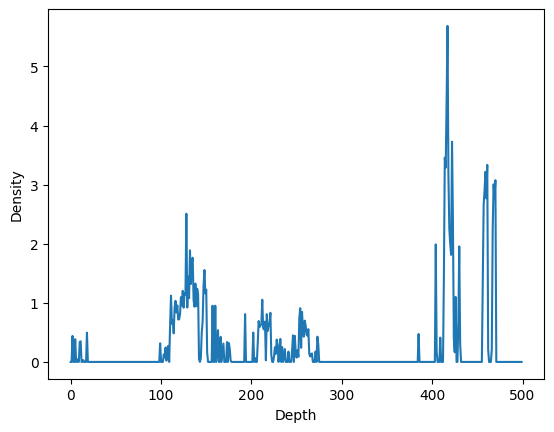

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

ax.plot(sigma[:500])

plt.show()

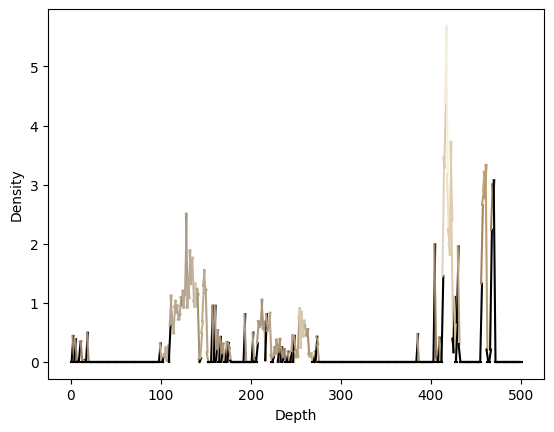

In [ ]:
fig_col = plt.figure()
ax = fig_col.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

# ax.set_ylim(0, 1)
for i in range(len(sigma[:500])):
    ax.plot([i,i+2],sigma[i:i+2],color=(tuple(rgb[i])))

plt.show()

In [ ]:
vairance_depth = 0
xyz = xyz_sampled[vairance_depth]

sampled_ray = ray[0].cpu().numpy()
testing_rays = []
size = 90
for i in range(size**2):
    testing_rays.append([xyz[0], xyz[1], xyz[2],(((i%90)-45)/360)+sampled_ray[3], ((int(i/90)-45)/360)+sampled_ray[4], sampled_ray[5]])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)

with torch.no_grad():
    tensorf.eval()
    output = tensorf.forward(testing_rays)

RuntimeError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 6.00 GiB total capacity; 5.08 GiB already allocated; 0 bytes free; 5.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
rgb_map = output[0].cpu().numpy()
rgb_map = rgb_map.reshape(size,size,3)
imgplot = plt.imshow(rgb_map)

ValueError: cannot reshape array of size 8112 into shape (90,90,3)